# ALPR: Automatic License Plate Recognition

From the police department to the parking lot, license plate recognition is a technology that has been used for years. It is a computer vision task that involves detecting and recognizing license plates from images or video streams. The goal of this project is to build an ALPR system using OpenCV and Tesseract OCR.

<center><img src="images/jupyter/speed_camera.jpg" width="400"/></center>
<center><a href="https://parkers-images.bauersecure.com/wp-images/176822/gatso_speed_camera.jpg">Speed Camera</a></center>

## Introduction
This repository showcases few implementations of ALPR, from using OpenCV to using deep learning models. The goal is to provide a comprehensive understanding of how ALPR works and how it can be implemented in different ways.

We split the project into two main parts:
1. **License Plate Detection**: This part focuses on detecting the license plate in an image or video stream.
2. **OCR (Optical Character Recognition)**: This part focuses on recognizing the characters on the detected license plate.

## License Plate Detection

### Methods
1. **Filtering**: Using image processing techniques to filter out the license plate from the rest of the image. This includes techniques like edge detection, contour detection, and morphological operations.

2. **YOLOv5**: Using the YOLOv5 deep learning model to detect the license plate in an image. It is a state-of-the-art object detection model that is fast and accurate.

### Filtering

First, lets import the required libraries and load the image.

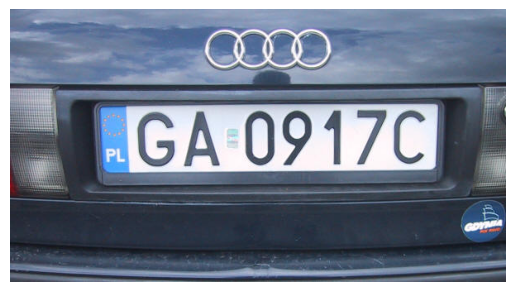

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

image = cv2.imread("images/car.jpg")

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

show_image(image)

Now, we will convert the image to grayscale, and then perform a **blackhat morphological operation** to highlight the text on the license plate. 

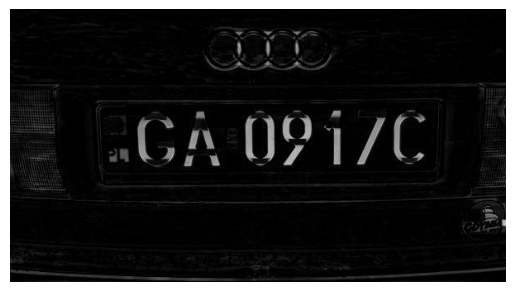

In [6]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))

blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

show_image(blackhat)

Now, we will create a **closing morphological operation** using a square kernel to isolate the bright regions (like license plate characters).

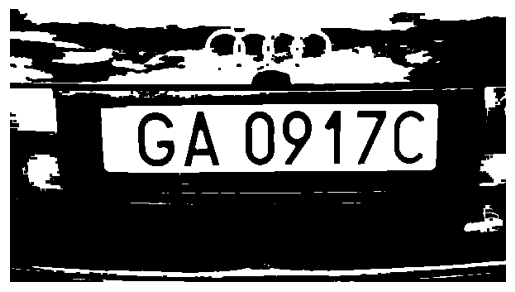

In [16]:
squareKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

light = cv2.morphologyEx(image, cv2.MORPH_CLOSE, squareKernel)
light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_image(light)

Next, we compute the **gradient in the x-direction** using the Sobel operator to find vertical edges, which are common in license plate characters.

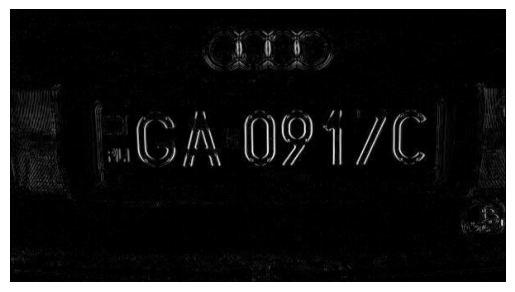

In [11]:
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)

(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")

show_image(gradX)

We now blur and close the gradient image to help connect components of the license plate, and apply **Otsu's thresholding** to binarize the image.

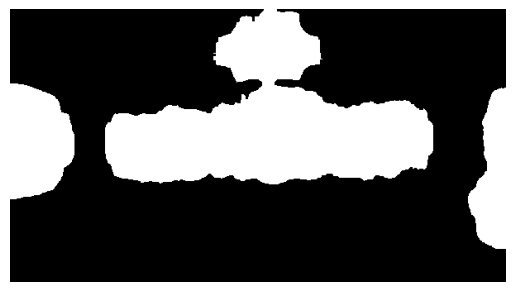

In [12]:
gradX = cv2.GaussianBlur(gradX, (81, 81), 200)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, squareKernel)

thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_image(thresh)

We then **bitwise AND** the thresholded image with the light regions to retain only the parts likely to be the license plate. We also perform **erosion and dilation** to clean up small noise.

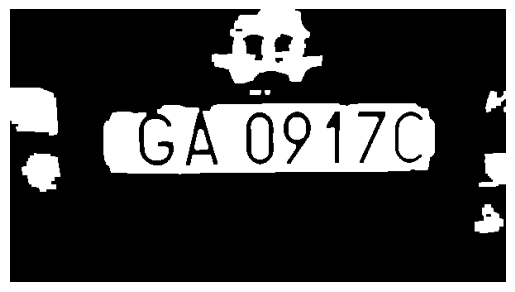

In [15]:
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

thresh = cv2.bitwise_and(thresh, thresh, mask=light)

thresh = cv2.dilate(thresh, None, iterations=2)
thresh = cv2.erode(thresh, None, iterations=1)

show_image(thresh)

Finally, we find contours to detect candidate license plate regions.

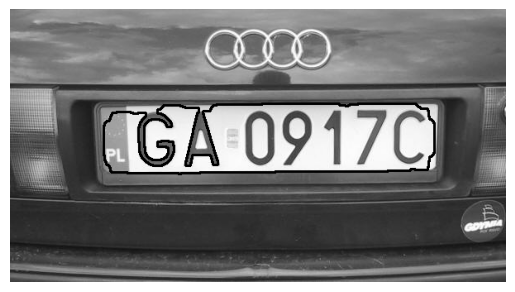

In [17]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:1]

output = image.copy()
cv2.drawContours(output, cnts, -1, (0, 255, 0), 2)
show_image(output)

Aspect Ratio:  4.662790697674419


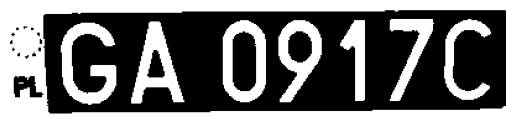

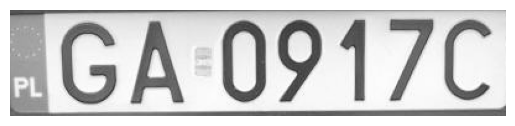

In [22]:
import Filtering.visual as visual

roi, licensePlateContours =  visual.locate_license_plate(image, cnts, minAR=4, maxAR=5)

show_image(roi)

(x, y, w, h) = cv2.boundingRect(licensePlateContours)
licensePlate = image[y:y + h, x:x + w]
show_image(licensePlate)

This approach however is not very robust, and it may not work well in all cases. For example, if the license plate is not clearly visible or if there are other objects in the image that are similar to the license plate, this approach may fail.

Aspect Ratio:  4.7740112994350286


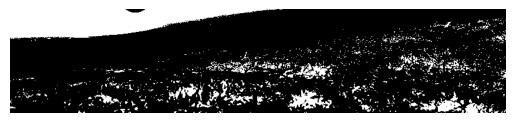

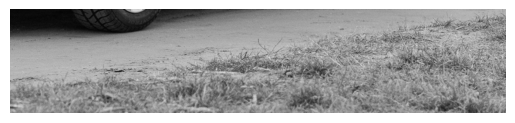

In [25]:
harder_image = cv2.imread("images/hard_car.jpg")

harder_image = cv2.cvtColor(harder_image, cv2.COLOR_BGR2GRAY)

cnts = visual.find_plate(harder_image)

roi, licensePlateContours =  visual.locate_license_plate(harder_image, cnts, minAR=4, maxAR=5)

show_image(roi)

(x, y, w, h) = cv2.boundingRect(licensePlateContours)
licensePlate = harder_image[y:y + h, x:x + w]
show_image(licensePlate)